In [16]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import glob
import pickle
import qiskit
from vcg.ansatz import FlexibleAnsatz

In [17]:
matplotlib.style.use("../../style.mplstyle")
plt.rcParams["font.size"] = 28
plt.rcParams["legend.fontsize"] = 20
plt.rcParams["font.family"] = "Latin Modern Math"

In [18]:
def compute_optimal_DHS(rho, R):
    """
    Computes D^*_HS when learning [rho]
    with a rank [R] approximation.
    """
    # compute \lambda's and sort them
    lam = np.sort(np.real(np.linalg.eigvals(rho)))
    d = len(lam)
    # compute lowest d - R lowest and R highest
    low_lam = np.array(lam[0:d-R])
    high_lam = np.array(lam[d-R:])
    N = (1 - np.sum(high_lam)) / R
    # compute cost
    #opt_DHS = np.sum(low_lam) + (1/R) * (1 - np.sum(high_lam))**2
    opt_DHS = np.sum(low_lam**2) +  R * N**2
    
    return opt_DHS

## Make 1 qubit plot

In [19]:
def get_rolling_mins(costs, window=10):
    """
    Gets the minimum value fo the cost at every window.
    """
    mins = []
    bins = int(np.floor(len(costs) / window))
    for b in range(bins):
        cost_window = costs[b * window:(b + 1) * window]
        mins.append(min(cost_window))
        
    cost_window = costs[(bins) * window:]
    if cost_window != []:
        mins.append(min(cost_window))
    
    return np.array(mins)

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

## Read in data

In [28]:
fa = FlexibleAnsatz(2, 'hef2d')
fa.update_parameters(R1_rho_params)
circ = fa.build_circ(2)
psi = circ.get_statevector()
rho0 = qiskit.quantum_info.partial_trace(psi, [0])
rho1 = qiskit.quantum_info.partial_trace(psi, [1])

In [31]:
# must generate rho from the parameters of the circuit
R1_rho_params = [6.12073495, 1.16120667, 3.38216267, 3.49973899, 1.8877114, 3.77717022,
 1.57383566, 0.656488,   3.68852582, 2.96791314, 2.84928064, 3.38561463,
 5.38226244, 0.30773205, 2.14503341]
fa = FlexibleAnsatz(2, 'hef2d')
fa.update_parameters(R1_rho_params)
circ = fa.build_circ(2)
psi = circ.get_statevector()
R1_rho = qiskit.quantum_info.partial_trace(psi, [0])
R1_opt = compute_optimal_DHS(R1_rho, 1)


R1_shot_cost = []
with open("rank_1_shot_cost.txt", 'r') as f:
    for l in f.readlines():
        R1_shot_cost.append(float(l))
        
R1_exact_cost = []
with open("rank_1_exact_cost.txt", 'r') as f:
    for l in f.readlines():
        R1_exact_cost.append(float(l))


R2_rho_params = [3.18893189, 6.27124987, 2.22112546, 1.47919731, 0.87348005, 2.96821423,
 6.10530066, 3.79836755, 6.11363481, 5.52379821, 1.69065155, 5.11802006,
 5.74336996, 4.01688969, 5.67435184]
fa = FlexibleAnsatz(2, 'hef2d')
fa.update_parameters(R2_rho_params)
circ = fa.build_circ(2)
psi = circ.get_statevector()
R2_rho = qiskit.quantum_info.partial_trace(psi, [0])
R2_opt = compute_optimal_DHS(R2_rho, 2)

R2_shot_cost = []
with open("rank_2_shot_cost.txt", 'r') as f:
    for l in f.readlines():
        R2_shot_cost.append(float(l))
        
R2_exact_cost = []
with open("rank_2_exact_cost.txt", 'r') as f:
    for l in f.readlines():
        R2_exact_cost.append(float(l))

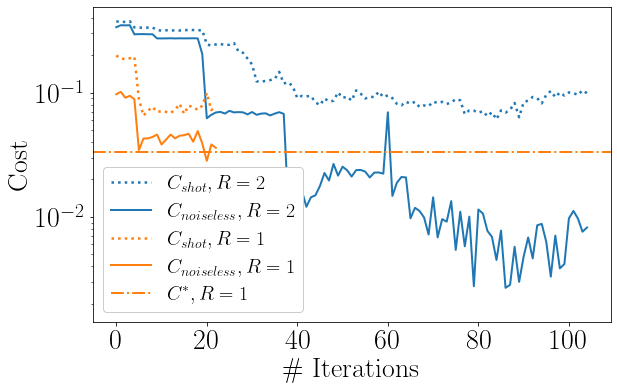

In [43]:
width = 5.8
fig = plt.figure(figsize=(1.6 * width, width))
c = colors[0]
f1 = plt.plot(get_rolling_mins(R2_shot_cost, 4), label=r"$C_{shot}, R=2$", color=c, linestyle=":", linewidth=2.5)
f2 = plt.plot(get_rolling_mins(R2_exact_cost, 4), label=r"$C_{noiseless}, R=2$", color=c)
c = colors[1]
g1 = plt.plot(get_rolling_mins(R1_shot_cost, 4), label=r"$C_{shot}, R=1$", color=c, linestyle=":", linewidth=2.5)
g2 = plt.plot(get_rolling_mins(R1_exact_cost, 4), label=r"$C_{noiseless}, R=1$", color=c)
g3 = plt.axhline(R1_opt, 0, 50, label=r"$C^*, R = 1$", color=c, linestyle="-.")

plt.yscale("log")
plt.ylabel("Cost")
plt.xlabel(r"\# Iterations")
plt.legend()
plt.savefig("plots/aliza_1q_result_CCPS.pdf", dpi=800, bbox_inches = 'tight')

In [166]:
R = 2
R2_shot, R2_exact, R2_rho, R2_sigma, R2_np = data_dict["bogota_1q_hadamard_prep_run_rank2_approx"]
R2_opt = compute_optimal_DHS(R2_rho, R)

sig_p, sig_v = np.linalg.eigh(R2_sigma)
p0 = sig_p[0]
v0 = sig_v[:,0]
p1 = sig_p[1]
v1 = sig_v[:,1]
pi_R1 = np.outer(v1, v1.conj())
R1_sigma = pi_R1 @ np.asarray(R2_sigma)
R1_sigma += (1 - np.trace(R1_sigma)) * pi_R1
R1_exact = np.real(np.trace(R1_sigma @ R1_sigma) + R2_rho.purity() - 2 * np.trace(R1_sigma @ np.asarray(R2_rho)))
R1_opt = compute_optimal_DHS(R2_rho, 1)

#R = 1
#R1_shot, R1_exact, R1_rho, R1_sigma, R1_np = data_dict["belem_1q_hadamard_prep_run_rank1_approx"]
#R1_opt = compute_optimal_DHS(R1_rho, R)

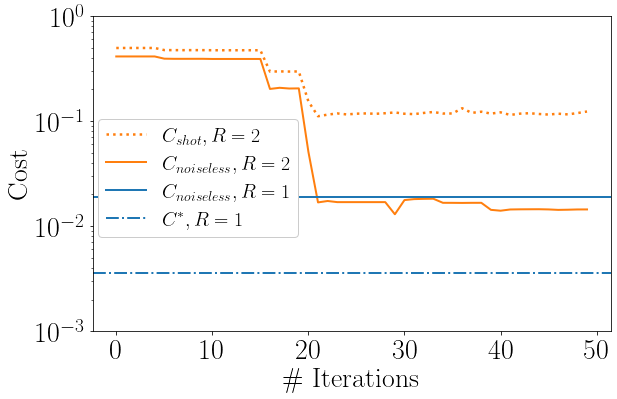

In [167]:
width = 5.8
fig = plt.figure(figsize=(1.6 * width, width))
c = colors[1]
plt.plot(get_rolling_mins(R2_shot, R2_np) +  (1.0 - np.real(R2_rho.purity())), label=r"$C_{shot}, R=2$", color=c, linestyle=":", linewidth=2.5)
plt.plot(get_rolling_mins(R2_exact, R2_np), label=r"$C_{noiseless}, R=2$", color=c)
c = colors[0]
plt.axhline(R1_exact, 0, 50, label=r"$C_{noiseless}, R = 1$", color=c)
plt.axhline(R1_opt, 0, 50, label=r"$C^*, R = 1$", color=c, linestyle="-.")

plt.yscale("log")
plt.ylabel("Cost")
plt.xlabel(r"\# Iterations")
plt.ylim(1e-3, 1)
plt.legend(ncol=1, loc=(0.01, 0.3))
#plt.legend()
plt.savefig("graphs/belem_1q_result_CCPS.pdf", dpi=800, bbox_inches = 'tight')